# MODEL PROJECT 

Imports and set magics:

In [6]:
# We start out by importing packages
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
from sympy import Symbol
import ipywidgets as widgets
from sympy.solvers import solve
sm.init_printing(use_unicode=True)
from IPython.display import display


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Description of Broydens method 

Boyden’s method is a numerical algorithm used for solving systems of nonlinear equations. It is an iterative method that finds the roots of a set of n nonlinear equations in n variables, where n can be any positive integer. 

It uses the secant method, which uses a finite difference approximation to estimate the Jacobian matrix. Here it uses the current approximation of the Jacobian matrix and the changes in the values of the variables, to compute a new estimate of the Jacobian matrix at the next iteration.

# Model description

The Solow-model with human capital can be described by the following equations: 

$K_t =$ Physical capital   

$H_t=$ Human capital 

$L_t =$ Labour

$A_t =$ Teknological level

The overall production function is: 

$Y_t = K_t^{\alpha}H_t^{\varphi}(A_tL_t)^{1-\alpha-\varphi}, \quad 0<\alpha<1, 0<\varphi<1, \alpha+\varphi<1$

The household decides how much to save of physical capital and of human capital.
The savings rate is hereby: 

$S_t = (s_K + s_H)Y_t$
Here $s_H$ denotes the savings of human kapital and $s_K$ denotes the savings of physical capital. 

Accumulation of Human capital: 
$ H_{t+1}=s_HY_t+(1-\delta)H_t, $

Accumulation of capital: 
$K_{t+1}=s_KY_t+(1-\delta)K_t  $ 

Accumulation of Technology: 
$  A_{t+1} = (1+g)A_t $

Accumulation of Labour:
$L_{t+1} = (1+n)L_t $

g denotes the growth rate in technology, n denotes the growthrate in the population and $\delta$ denotes the depreciation in capital

To construct the transition equations we need to define the "tilde" variables: 

$\tilde{k}_{t}= \frac{K_t}{A_tL_t}$

$\tilde{h}_{t}= \frac{H_t}{A_tL_t}$

From here we can construct the two transition eqations used to construct the nullclines: 

For physical capital: 
$\tilde{k}_{t+1} = \frac{1}{(1+n)(1+g)}(s_K\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1+{\delta})\tilde{k}_{t})$

For human capital: 
$\tilde{h}_{t+1} = \frac{1}{(1+n)(1+g)}(s_H\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1+{\delta})\tilde{h}_{t})$

The two hull-clines are defined as: 

$\tilde{k}_{t+1}-\tilde{k}_{t} = \frac{1}{(1+n)(1+g)}(s_K\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}-(n+g+{\delta}+ng)\tilde{k}_{t})$

$\tilde{h}_{t+1}-\tilde{h}_{t} = \frac{1}{(1+n)(1+g)}(s_H\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}-(n+g+{\delta}+ng)\tilde{h}_{t})$

# Analytical solution

In [7]:
# First we define our symbols:
k_tilde = sm.symbols("ktilde_t")
h_tilde = sm.symbols("htilde_t")
alpha = sm.symbols("alpha")
phi = sm.symbols("phi")
delta = sm.symbols("delta")
g = sm.symbols("g")
n = sm.symbols("n")
sK = sm.symbols("s_K")
sH = sm.symbols("s_H")

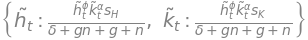

In [8]:
# First we define the transition equations:
k_trans = sm.Eq(k_tilde, 1/((1+n)*(1+g)) * (sK * k_tilde**alpha * h_tilde**phi + (1-delta) * k_tilde))
h_trans = sm.Eq(h_tilde, 1/((1+n)*(1+g)) * (sH * k_tilde**alpha * h_tilde**phi + (1-delta) * h_tilde))

# Solving the transition equations
sm.nonlinsolve([k_trans, h_trans], [k_tilde, h_tilde])
ss = sm.solve((k_trans, h_trans),(k_tilde,h_tilde), implicit=True, manual=True)
display(ss)

# Numerical solution

We use the broyden algorithm described above in a numerical optimizer to find the numerical solution for our model

In [9]:
# Setting realtistic values for our parameters
alpha_v = 0.33
phi_v = 0.4
delta_v = 0.06
g_v = 0.02
n_v = 0.01
sK_v = 0.27
sH_v = 0.27

# Generating the values for our k_tilde
k_values = np.linspace(0, 2500, 1000)

In [10]:
# We define a function where the transition for physical capital equation has been isolated on the right side of the equation
def k_trans_func(k_tilde, h_tilde, sK_v, sH_v, alpha_v, phi_v, delta_v, n_v, g_V):
    return (h_tilde**phi_v * k_tilde**alpha_v *sK_v +k_tilde*(1-delta_v))/((g_v+1) * (n_v+1)) -k_tilde

# Same for human capital
def h_trans_func(k_tilde, h_tilde, sK_v, sH_v, alpha_v, phi_v, delta_v, n_v, g_V):
    return (h_tilde**phi_v * k_tilde**alpha_v *sH_v +h_tilde*(1-delta_v))/((g_v+1) * (n_v+1)) -h_tilde

# We define a lambda function containing both our functions, where k_tilde & h_tilde are set as x[0] & x[1] as we want the values that gives the optimal solution
objective = lambda x: [k_trans_func(x[0], x[1], sK_v, sH_v, alpha_v, phi_v, delta_v, n_v, g_v), 
                       h_trans_func(x[0], x[1], sK_v, sH_v, alpha_v, phi_v, delta_v, n_v, g_v)]  

# Setting initial guess
intial_guess =[1,1]

# Creating optimizer
result = optimize.root(objective, intial_guess, method = "broyden1")

print(f'From our optimizer we get the numerical solution: k* = {result.x[1]:.2f}, h* = {result.x[0]:.2f}')

From our optimizer we get the numerical solution: k* = 58.02, h* = 58.02


C:\Users\Asger Thimmer\AppData\Local\Temp\ipykernel_12152\459579996.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (h_tilde**phi_v * k_tilde**alpha_v *sK_v +k_tilde*(1-delta_v))/((g_v+1) * (n_v+1)) -k_tilde
C:\Users\Asger Thimmer\AppData\Local\Temp\ipykernel_12152\459579996.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (h_tilde**phi_v * k_tilde**alpha_v *sH_v +h_tilde*(1-delta_v))/((g_v+1) * (n_v+1)) -h_tilde
c:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_nonlin.py:912: RuntimeWarning: invalid value encountered in divide
  d = v / vdot(df, v)


# Visual solution

To make the visual solution we derive the nullclines from our transition equations and plot them in a phasediagram. The SS for $\tilde{k}_{t}$ & $\tilde{h}_{t}$ is where to the lines cross each other.

In [11]:
# Isolating h_tilde in the transition equation and setting it equal to 0  
k_solve = sm.solve(k_trans,h_tilde)[0]
h_solve = sm.solve(h_trans,h_tilde)[0]


# We convert our nullclines into python functions
k_null_py = sm.lambdify([k_tilde, alpha, delta, g, n, phi, sK], k_solve)
h_null_py = sm.lambdify([k_tilde, alpha, delta, g, n, phi, sH], h_solve)


# Defining the plot for our nullclines
def phasediagram(alpha_guess, phi_guess, sK_guess, sH_guess):
    # Inserting k_values into our nullclines
    k_null_display = k_null_py(k_values, alpha_guess, delta_v, g_v, n_v, phi_guess, sK_guess)
    h_null_display = h_null_py(k_values, alpha_guess, delta_v, g_v, n_v, phi_guess, sH_guess)

    # Making plot
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(k_values, k_null_display)
    ax.plot(k_values, h_null_display)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    # setting labels and title
    ax.set_title('Phasediagram')
    ax.set_xlabel('k_tilde')
    ax.set_ylabel('h_tilde')
    ax.grid(True, linewidth=1)

    

# Setting initial values for parameters
alpha_guess = 0.33
phi_guess = 0.4
sK_guess = 0.27
sH_guess = 0.27

# Making a button to reset the value of our sliders to the initial value
reset_button = widgets.Button(description="Reset sliders")

# Defining the button
def reset_sliders(button):
    alpha_slider.value = alpha_guess
    phi_slider.value = phi_guess
    sK_slider.value = sK_guess
    sH_slider.value = sH_guess
reset_button.on_click(reset_sliders)
display(reset_button)


# Creating our sliders 
alpha_slider = widgets.FloatSlider(
                min=0.1, max=1, step=0.01, value=alpha_guess, description="Alpha:")
phi_slider = widgets.FloatSlider(
                min=0.1, max=1, step=0.01, value=phi_guess, description="Phi:")
sK_slider = widgets.FloatSlider(
                min=0.1, max=1, step=0.01, value=sK_guess, description="sK:")
sH_slider = widgets.FloatSlider(
                min=0.1, max=1, step=0.01, value=sH_guess, description="sH:")

# Adding the sliders to our diagram
widgets.interact(phasediagram, 
                alpha_guess=alpha_slider,
                phi_guess=phi_slider,
                sK_guess=sK_slider,
                sH_guess=sH_slider
                )

plt.show()    

Button(description='Reset sliders', style=ButtonStyle())

interactive(children=(FloatSlider(value=0.33, description='Alpha:', max=1.0, min=0.1, step=0.01), FloatSlider(…

# Simulating model with a changeable shock to sK

In [12]:
# We define our initial values
k0 = 1
h0 = 1
a0 = 1
l0 = 1
t0 = 0
T = 250

# Creating arrays for storing the values produced by the model
k_capital = np.zeros(T+1)
h_capital = np.zeros(T+1)
y_output = np.zeros(T+1)
l_workers = np.zeros(T+1)
a_tech = np.zeros(T+1)
y_growth = np.zeros(T+1)
t = np.arange(T)

# Storing initial values in our arrays
k_capital[0] = k0
h_capital[0] = h0
a_tech[0] = a0
l_workers[0] = l0
y_growth = []

# We define a function including our simulation and the plot
def sK_shock(shock):
    # Creating a for loop that runs the simulation for T periods
    for i in range(T):
        # if-statement that creates permenant shock to sK from periode 3 and onwards
        if i <= 2:
            sK_v = 0.1
        else:
            sK_v = shock    

        # The equations that make up the model
        y_output[i+1] = k_capital[i]**alpha_v * h_capital[i]**phi_v * (a_tech[i]*l_workers[i])**(1-alpha_v-phi_v)
        l_workers[i+1] = (1+n_v) * l_workers[i]
        a_tech[i+1] = (1+g_v) * a_tech[i]
        k_capital[i+1] = sK_v * y_output[i] + (1-delta_v) * k_capital[i]
        h_capital[i+1] = sH_v * y_output[i] + (1-delta_v) * h_capital[i]

        # Calculating the groth in y
        y_growth.append(np.log(y_output[i+1])-np.log(y_output[i]))

    # Plotting the simulation
    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(y_growth[2:], color="blue")
    plt.axhline(y_growth[249],xmax=1,color="black",linestyle="--")
    ax.set_ylabel('Growth in y')
    ax.set_xlabel('Time')
    ax.set_title('Growth in y, solow model with human capital')
    ax.legend()

# Setting the slider parameters
shock_slider = widgets.FloatSlider(
                min=0.12, max=1, step=0.01, value=0.2, description="sK:",continuous_update=False)

# Defining the slider 
def shock_update(shock):
    sK_shock(shock)
    # Clearing y_growth list to allow for new values
    y_growth.clear() 
    plt.show()

# Adding the sliders to our diagram
widgets.interact(shock_update, shock=shock_slider)



interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='sK:', max=1.0, min=0.12, st…

<function __main__.shock_update(shock)>

# Extension: Simulating solow model with human capital and oil

C:\Users\Asger Thimmer\AppData\Local\Temp\ipykernel_12152\1016608424.py:50: RuntimeWarning: divide by zero encountered in log
  y_growth_vE.append(np.log(y_output[i+1])-np.log(y_output[i])) # Growth in output appended to list
C:\Users\Asger Thimmer\AppData\Local\Temp\ipykernel_12152\1016608424.py:50: RuntimeWarning: invalid value encountered in double_scalars
  y_growth_vE.append(np.log(y_output[i+1])-np.log(y_output[i])) # Growth in output appended to list
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


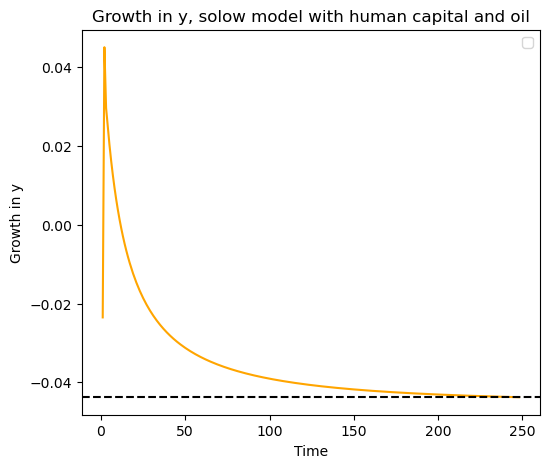

In [16]:
# Setting values for additional parameters
alpha_vE = 0.25
phi_vE = 0.25
beta_vE = 0.25
epsilon_vE = 0.25
delta_v = 0.06
g_v = 0.02
n_v = 0.01
sK_v = 0.1
sH_v = 0.1
sR_v = 0.1

# We define our initial values
k0 = 1
h0 = 1
a0 = 1
l0 = 1
t0 = 0
r0 = 100
T = 250

# Create arrays for storing the values produced by the model
k_capital = np.zeros(T+1)
h_capital = np.zeros(T+1)
y_output = np.zeros(T+1)
l_workers = np.zeros(T+1)
a_tech = np.zeros(T+1)
e_extraction = np.zeros(T+1)
y_growth_vE = np.zeros(T+1)
r_oil = np.zeros(T+1)
t = np.arange(T)

# Storing initial values in our arrays
k_capital[0] = k0
h_capital[0] = h0
a_tech[0] = a0
l_workers[0] = l0
r_oil[0] = r0
y_growth_vE = []

# Setting for loop that simulates the model
for i in range(T):
    e_extraction[i+1] = sR_v*r_oil[i] # Amount of oil extracted
    r_oil[i+1] = r_oil[i] - e_extraction[i] # Oil remaining for next period
    y_output[i+1] = k_capital[i]**alpha_vE * h_capital[i]**phi_vE * (a_tech[i]*l_workers[i])**beta_vE *e_extraction[i]**epsilon_vE # Output next period
    l_workers[i+1] = (1+n_v) * l_workers[i] # Workers next periode
    a_tech[i+1] = (1+g_v) * a_tech[i] # Technology next period
    k_capital[i+1] = sK_v * y_output[i] + (1-delta_v) * k_capital[i] # Physical capital next period
    h_capital[i+1] = sH_v * y_output[i] + (1-delta_v) * h_capital[i] # Human capital next period
    y_growth_vE.append(np.log(y_output[i+1])-np.log(y_output[i])) # Growth in output appended to list
    

# Plotting the simulation
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,2,1)
ax.plot(y_growth_vE[1:], color="orange")
plt.axhline(y_growth_vE[249],xmax=1, color="black", linestyle="--")
ax.set_ylabel('Growth in y')
ax.set_xlabel('Time')
ax.set_title('Growth in y, solow model with human capital and oil')
ax.legend()

plt.show()


# Conclusion

To conclude our model project we have described the solow model with human capital. Made an analytical, numerical and visual solution. Simulated the the model with a changable shock variable and extended the model with oil. 

We can conclude that an increase in the savingsrate for physical capital increases the initial growth i y. On top of this we can conclude from our visual solution of the model that an increase in either the svaingsrate of human capital $s_H$ or the savingsrate physical capital $s_K$ will increase the steadysate ceteris paribus.

Futhermore we can conclude from our analysis that if we add oil to the model as a diminising nature resource the growth in y will be negative approximately after 20 periods.  